In [103]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.stats as sts
from scipy.integrate import quad
import scipy.optimize as opt
import scipy.special as sp

In [104]:
data = np.loadtxt('../data/usincmoms.txt')
bin_percents = data[:, 0]
bin_centers = data[:, 1]

In [105]:
bins = np.concatenate(((bin_centers[:-2] - 2500) / 1000, np.array([200, 250, 350])))
weights = np.concatenate((bin_percents[:-2]/5, np.array([bin_percents[-2] / (50), bin_percents[-1] / (100)])))

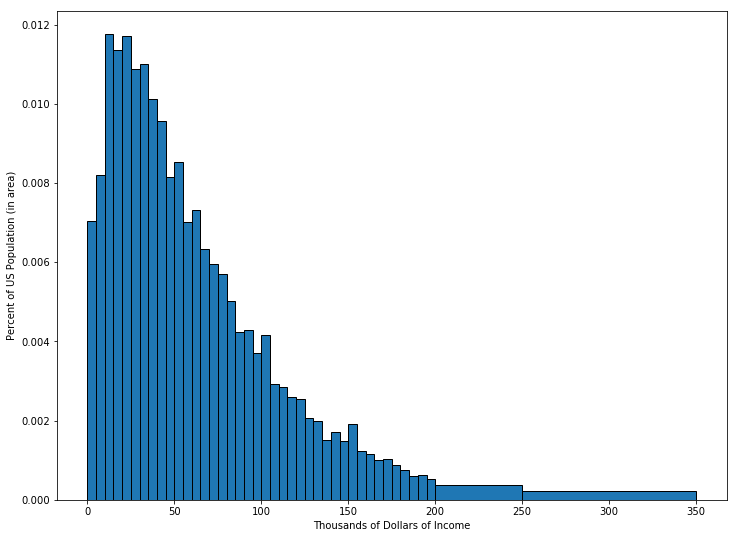

In [106]:
plt.subplots(figsize=(12, 9))
count, bins, ignored = plt.hist(bin_centers / 1000, bins=bins, weights=weights, edgecolor='black')
plt.xlabel('Thousands of Dollars of Income')
plt.ylabel('Percent of US Population (in area)')
plt.show()

In [107]:
def LN_pdf(xvals, sigma, mu):
    pdf_vals = sts.lognorm.pdf(xvals, sigma, mu, np.exp(mu))
    pdf_vals[pdf_vals == 0] = 1e-10
    return pdf_vals

In [108]:
def model_moments_LN(bins, sigma, mu):
    n = bins.shape[0]
    moments = np.empty(n - 1)
    xfx = lambda x: x * LN_pdf(np.array([x]), sigma, mu)
    for i in range(n - 1):
        moments[i] = quad(xfx, bins[i], bins[i + 1])[0]
    return moments

In [109]:
def data_moments(bins, weights):
    n = bins.shape[0]
    moments = np.empty(n - 1)
    for i in range(n - 1):
        moments[i] = quad(lambda x: weights[i]*x, bins[i], bins[i + 1])[0]
    return moments

In [110]:
def err_vec_LN(weights, bins, sigma, mu):
    data_moms = data_moments(bins, weights)
    model_moms = model_moments_LN(bins, sigma, mu)
    return (model_moms - data_moms) / data_moms

In [111]:
def crit_LN(params, weights, bins, W):
    sigma, mu = params
    err = err_vec_LN(weights, bins, sigma, mu)
    crit_val = np.dot(np.dot(err.T, W), err)
    return crit_val

In [112]:
W = np.diag(bin_percents)
sigma_init = 1
mu_init = np.log(np.sum(weights * bin_centers / 1000))
params_init_LN = np.array([sigma_init, mu_init])
results_LN = opt.minimize(crit_LN, params_init_LN, args=(weights, bins, W),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
sigma_GMM_LN, mu_GMM_LN = results_LN.x
print(' sigma_GMM_LN =', sigma_GMM_LN, 'mu_GMM_LN =', mu_GMM_LN)
print('Value of minimized crit function: ', crit_LN((sigma_GMM_LN, mu_GMM_LN), weights, bins, W))

 sigma_GMM_LN = 1.03980096732 mu_GMM_LN = 3.83925284181
Value of minimized crit function:  0.0611799613458


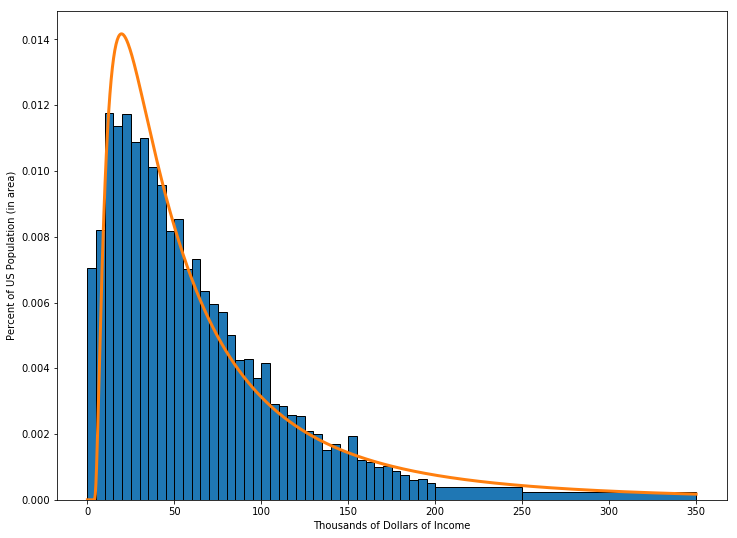

In [113]:
plt.subplots(figsize=(12, 9))
dist_pts = np.linspace(0, 350, 1000)
count, bins, ignored = plt.hist(bin_centers / 1000, bins=bins, weights=weights, edgecolor='black')
plt.plot(dist_pts, LN_pdf(dist_pts, sigma_GMM_LN, mu_GMM_LN), lw=3)
plt.xlabel('Thousands of Dollars of Income')
plt.ylabel('Percent of US Population (in area)')
plt.show()

In [114]:
def GA_pdf(xvals, alpha, beta):
    pdf_vals = ((xvals ** (alpha - 1)) * np.exp(-xvals / beta)) / ((beta ** alpha) * sp.gamma(alpha))
    pdf_vals[pdf_vals == 0] = 1e-10
    return pdf_vals

In [115]:
def model_moments_GA(bins, alpha, beta):
    n = bins.shape[0]
    moments = np.empty(n - 1)
    xfx = lambda x: x * GA_pdf(np.array([x]), alpha, beta)
    for i in range(n - 1):
        moments[i] = quad(xfx, bins[i], bins[i + 1])[0]
    return moments

In [116]:
def err_vec_GA(weights, bins, alpha, beta):
    data_moms = data_moments(bins, weights)
    model_moms = model_moments_GA(bins, alpha, beta)
    return (model_moms - data_moms) / data_moms

In [117]:
def crit_GA(params, weights, bins, W):
    alpha, beta = params
    err = err_vec_GA(weights, bins, alpha, beta)
    crit_val = np.dot(np.dot(err.T, W), err)
    return crit_val

In [118]:
alpha_init = 3
beta_init = 20
params_init_GA = np.array([alpha_init, beta_init])
results_GA = opt.minimize(crit_GA, params_init_GA, args=(weights, bins, W),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
alpha_GMM_GA, beta_GMM_GA = results_GA.x
print(' alpha_GMM_GA =', alpha_GMM_GA, 'beta_GMM_GA =', beta_GMM_GA)
print('Value of minimized crit function: ', crit_GA((alpha_GMM_GA, beta_GMM_GA), weights, bins, W))

 alpha_GMM_GA = 1.39954857369 beta_GMM_GA = 47.1379667912
Value of minimized crit function:  0.0151661984697


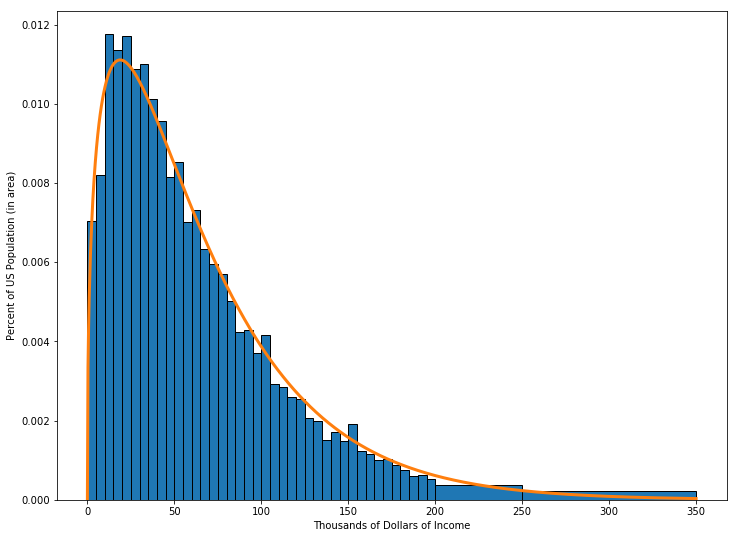

In [120]:
plt.subplots(figsize=(12, 9))
dist_pts = np.linspace(0, 350, 1000)
count, bins, ignored = plt.hist(bin_centers / 1000, bins=bins, weights=weights, edgecolor='black')
plt.plot(dist_pts, GA_pdf(dist_pts, alpha_GMM_GA, beta_GMM_GA), lw=3)
plt.xlabel('Thousands of Dollars of Income')
plt.ylabel('Percent of US Population (in area)')
plt.show()

Since we used the same weighting matrix $W$, and our err_vec was in percents in both cases, we may use the minimized crit value to compare how well each distribution fits the data. Since the minimized crit value for the GA distribution is smaller, it fits the data better.

In [121]:
err_LN = err_vec_LN(weights, bins, sigma_GMM_LN, mu_GMM_LN)
VCV2_LN = np.outer(err_LN, err_LN) / weights.shape[0]

# Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
W_LN_twostep = la.pinv(VCV2_LN)

In [122]:
params_init_LN_twostep = np.array([0.6, 3.9])
results_LN_twostep = opt.minimize(crit_LN, params_init_LN_twostep, args=(weights, bins, W_LN_twostep),
                     method='L-BFGS-B', bounds=((1e-10, sigma_GMM_LN * 2), (1e-10, mu_GMM_LN * 2)))
sigma_GMM_LN_twostep, mu_GMM_LN_twostep = results_LN_twostep.x
dist = ((sigma_GMM_LN - sigma_GMM_LN_twostep) ** 2 + (mu_GMM_LN - mu_GMM_LN_twostep) ** 2) ** 0.5
print(' sigma_GMM_LN_twostep =', sigma_GMM_LN_twostep, 'mu_GMM_LN_twostep =', mu_GMM_LN_twostep)
print('Value of minimized crit function: ', crit_LN((sigma_GMM_LN_twostep, mu_GMM_LN_twostep), weights, bins, W_LN_twostep))

 sigma_GMM_LN_twostep = 0.610338525078 mu_GMM_LN_twostep = 3.8950394956
Value of minimized crit function:  7.24527654707e-15


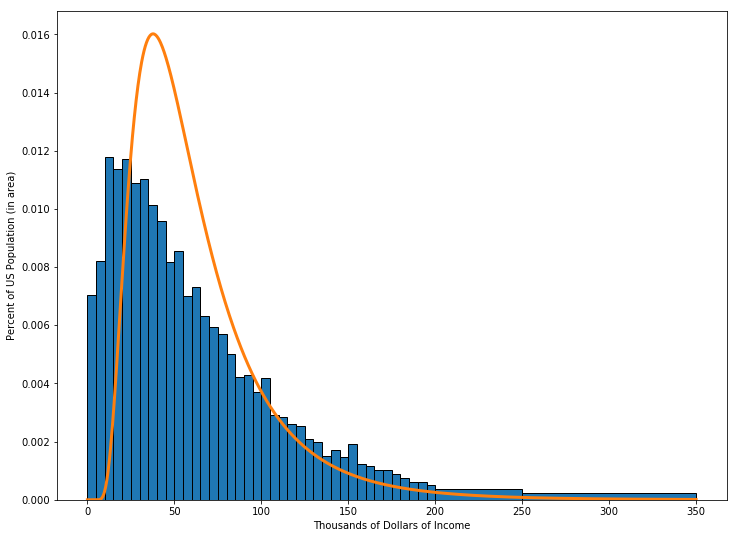

In [124]:
plt.subplots(figsize=(12, 9))
dist_pts = np.linspace(0, 350, 1000)
count, bins, ignored = plt.hist(bin_centers / 1000, bins=bins, weights=weights, edgecolor='black')
plt.plot(dist_pts, LN_pdf(dist_pts, sigma_GMM_LN_twostep, mu_GMM_LN_twostep), lw=3)
plt.xlabel('Thousands of Dollars of Income')
plt.ylabel('Percent of US Population (in area)')
plt.show()

In [125]:
err_GA = err_vec_GA(weights, bins, alpha_GMM_GA, beta_GMM_GA)
VCV2_GA = np.outer(err_GA, err_GA) / weights.shape[0]

# Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
W_GA_twostep = la.pinv(VCV2_GA)

In [126]:
params_init_GA_twostep = np.array([2, 40])
#Note that this is very sensitive to initial values!
results_GA_twostep = opt.minimize(crit_GA, params_init_GA_twostep, args=(weights, bins, W_GA_twostep),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
alpha_GMM_GA_twostep, beta_GMM_GA_twostep = results_GA_twostep.x
print(' alpha_GMM_GA_twostep =', alpha_GMM_GA_twostep, 'beta_GMM_GA_twostep =', beta_GMM_GA_twostep)
print('Value of minimized crit function: ', crit_GA((alpha_GMM_GA_twostep, beta_GMM_GA_twostep), weights, bins, W_GA_twostep))

 alpha_GMM_GA_twostep = 1.56995911928 beta_GMM_GA_twostep = 34.1180379381
Value of minimized crit function:  -4.05471525256e-16


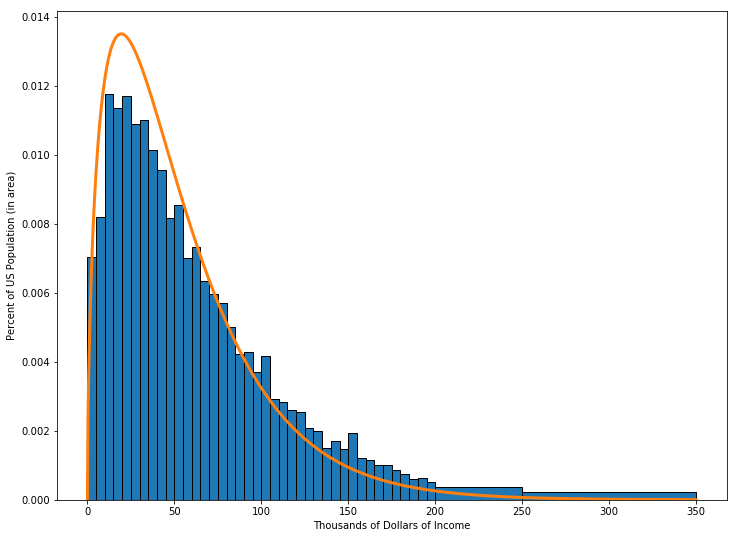

In [128]:
plt.subplots(figsize=(12, 9))
dist_pts = np.linspace(0, 350, 1000)
count, bins, ignored = plt.hist(bin_centers / 1000, bins=bins, weights=weights, edgecolor='black')
plt.plot(dist_pts, GA_pdf(dist_pts, alpha_GMM_GA_twostep, beta_GMM_GA_twostep), lw=3)
plt.xlabel('Thousands of Dollars of Income')
plt.ylabel('Percent of US Population (in area)')
plt.show()

The fit of the two step distributions is extremely sensitive to initial values - much more so than the previous distributions. So, I would say that in this case, using a two step process is not a viable method for obtaining useful results.